# Analyse Rotation Spectra - Plots

## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan, interp
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path
from scipy.stats import median_absolute_deviation as mad

import pickle
import matplotlib.pyplot as plt

In [2]:
!ls "/import/kilauea-data/ROMY/RotationSpectra/data"

overview		      run_2019_WET-Z_3600_testday  run_N2_RLAS_7200
run_2019_FUR-Z_3600	      run_2021_RPFO-E_3600	   run_N2_RLAS-Z_1800
run_2019_FUR-Z_3600_testday   run_2021_RPFO-N_3600	   run_N2_RLAS-Z_3600
run_2019_RLAS-Z_3600	      run_2021_RPFO-Z_3600	   run_N2_ROMY
run_2019_RLAS-Z_3600_testday  run_2022_ROMY-Z_3600	   run_N2_ROMY-Z_7200
run_2019_ROMY-E_3600	      run_N1_RLAS		   run_N3_RLAS-Z_3600
run_2019_ROMY-Z_3600	      run_N1_ROMY		   run_N3_ROMY-Z_3600
run_2019_ROMY-Z_3600_testday  run_N2019_RLAS-Z_3600	   testinterval
run_2019_WET-Z_3600	      run_N2019_ROMY-Z_3600


## Configurations

In [3]:
# inname = "run_2021_ROMY-Z_86400_pfo-days"
# inname = "run_2021_RPFO-E_3600"
inname = "run_2019_ROMY-Z_3600"


inpath = f"/import/kilauea-data/ROMY/RotationSpectra/data/{inname}/"

config = pickle.load(open(inpath+inname+"_config.pkl", 'rb'))

config['save'] = True

config['inname'] = inname
config['inpath'] = inpath

config['frequency_limits'] = [0.0001, 1]

## Looping 

In [4]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [5]:
def __get_minimum_psd(psds, f_tmp):
    
    from numpy import median
    
    f_before = f_tmp[0]
    f_tmp[0] = 1e-9
    
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = (psds[0]/f_tmp).sum()
#             lowest_value = median(psds[0]/f_tmp)
            idx = 0

        value = (psd/f_tmp).sum() 
#         value = median(psd/f_tmp)
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    f_tmp[0] = f_before      
    
    return psds[idx]

In [6]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [7]:
def __remove_noisy_psds(df, threshold_mean=1e-13):

    from numpy import delete
    
    l1 = len(df.columns)
    for col in df.columns:
#         print(col, type(col))
        if df[col].astype(float).mean() > threshold_mean:
            df = df.drop(columns=col)
    l2 = len(df.columns)
    print(f" -> removed {l1-l2} columns due to mean thresholds!")
    print(f" -> {l2} psds remain")
    
    return df

In [8]:
## load set of minimum psds
file = f"{config['inpath']}{config['inname']}_daily_medians.pkl"
print(f" -> loading \n {file} ...")
psds_all = read_pickle(file)

## load frequencies
ff = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pkl", 'rb'))

 -> loading 
 /import/kilauea-data/ROMY/RotationSpectra/data/run_2019_ROMY-Z_3600/run_2019_ROMY-Z_3600_daily_medians.pkl ...


In [9]:
# if "RLAS-Z" in config['inname'].split("_"):
#     psds_all = __remove_noisy_psds(psds_all, threshold_mean=1e-21)
# elif "ROMY-Z" in config['inname'].split("_"):
#     psds_all = __remove_noisy_psds(psds_all, threshold_mean=1e-19)

Select Time Period

In [10]:
dates = date_range(start="2019-01-01", end="2019-08-05")

dates = [str(dd).split(" ")[0].replace("-","") for dd in dates]

tmp = DataFrame()
for d in dates:
    if d in psds_all.columns:
        print(d)
        tmp[d] = psds_all[d]
psds_all = tmp

20190102
20190103
20190104
20190105
20190106
20190107
20190108
20190109
20190110
20190111
20190112
20190113
20190114
20190115
20190116
20190117
20190118
20190119
20190120
20190121
20190122
20190123
20190124
20190125
20190126
20190127
20190128
20190129
20190130
20190131
20190201
20190202
20190203
20190204
20190205
20190206
20190207
20190208
20190209
20190210
20190211
20190212
20190213
20190214
20190215
20190216
20190217
20190218
20190219
20190220
20190221
20190222
20190223
20190224
20190225
20190226
20190227
20190228
20190301


Convert dataframes to array / matrix

In [11]:
psds = __get_array_from_dataframe(psds_all)

columns = psds_all.columns

Cut to frequency axis and matrices to frequency limits as specified in config

In [12]:
ind = []
for i,f in enumerate(ff):
    if f >= config['frequency_limits'][0] and f <= config['frequency_limits'][1]:
        ind.append(i)

ff = ff[ind[0]:ind[-1]]
psds = psds[:,ind[0]:ind[-1]]

## Plotting

In [13]:
def __makeplot_colorlines(config, ff, psds, columns):

    from numpy import isnan, median, mean, std, array
    from scipy.stats import median_abs_deviation as mad
    
    psds_median, psds_mean, psds_std, psds_mad = [],[],[],[]
    for fcross in range(psds.shape[1]):
        data = psds[:,fcross]
        psds_median.append(median(data[~isnan(data)]))
        psds_mean.append(mean(data[~isnan(data)]))
        psds_std.append(std(data[~isnan(data)]))
        psds_mad.append(mad(data[~isnan(data)]))
        
    psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)
    
        
    ff = 1/ff
        
    ##____________________________
    
    fig, ax = plt.subplots(1,1, figsize=(15,10), sharey=False, sharex=True)

    font = 12

    N = psds.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))


    for n, psd in enumerate(psds):
        ax.loglog(ff, psd, color=colors[n], alpha=0.7)


    ## add scatter for colorbar object only
    for n, psd in enumerate(psds):
        p2 = ax.scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)


#     ax.loglog(ff, psds_median, 'black', zorder=3, alpha=0.9, label="median")
#     ax.loglog(ff, psds_mean, 'black', zorder=3, alpha=0.9)


#     ax.loglog(ff, psds_minimal, 'grey', zorder=2, alpha=1.0, label="minimal")
#     ax.loglog(ff, psds_minimum, 'k', zorder=2, alpha=0.8)
    

#     ax.set_title("Minimal PSD", fontsize=font)
#     ax.set_title("Minimum PSD", fontsize=font)

    ax.set_xlabel("Period (s)", fontsize=font)

    ax.set_ylabel(r"PSD (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    
    ax.grid(True, which="both", ls="-", alpha=0.5)
    
    ax.set_xlim(min(ff), max(ff))
#     ax.set_xlim(10**log10(config['frequency_limits'][0]), 10**log10(config['frequency_limits'][1]))
    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
#     new_ticks=[]
#     for n, t in enumerate(cbar.get_ticks()):
#         print(n)
#         new_ticks.append(columns[int(t)])
#     print(new_ticks)
#     cbar.ax.set_xticklabels(columns)

    ax.legend()

    plt.show();
    
    out = DataFrame()
    out['frequencies'] = ff
    out['psds_minimal'] = array(psds_minimal)
    out['psds_median'] = array(psds_median)
    out['psds_mean'] = array(psds_mean)
    out['psds_std'] = array(psds_std)
    out['psds_mad'] = array(psds_mad)
    
    
    return fig, out

No handles with labels found to put in legend.


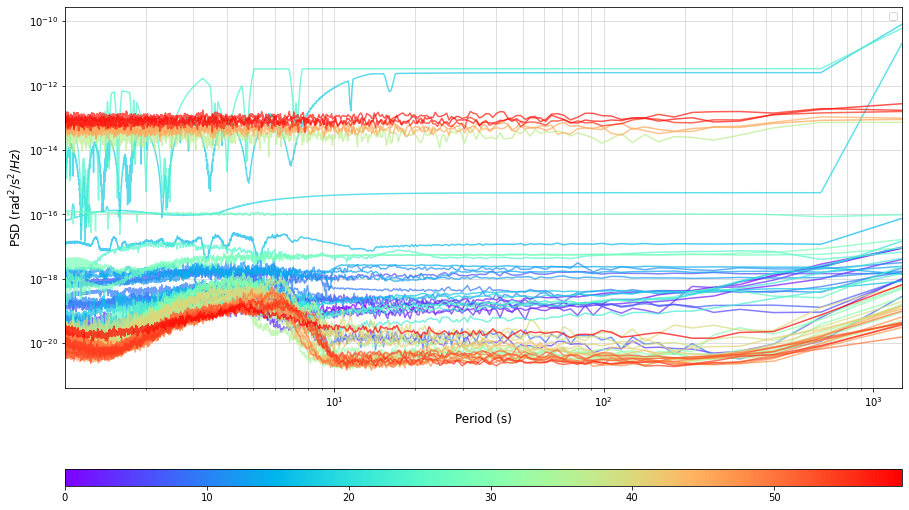

In [14]:
fig, out = __makeplot_colorlines(config, ff, psds, columns)

### Write to File

In [15]:
# if config['save']:
#     out.to_pickle(f"{inpath}{inname}_stats.pkl")
#     print(f" -> writing to {inpath}{inname}_stats.pkl")

In [16]:
ff = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pkl", 'rb'))
periods = zeros(len(ff))
periods[:-1] = 1/ff[1:]


path="/import/kilauea-data/ROMY/RotationSpectra/data/"

interval=3600


rlnm = read_csv("/export/data/LNM/data/MODELS/"+"rlnm_theory.csv")
rlnm_periods = rlnm['period']
rlnm_psd = rlnm['rlnm_psd_median']

sta = "ROMY-Z"
romyz = read_pickle(path+f"run_2019_{sta}_{interval}_testday/run_2019_{sta}_{interval}_testday_daily_medians.pkl")

sta = "RLAS-Z"
rlasz = read_pickle(path+f"run_2019_{sta}_{interval}_testday/run_2019_{sta}_{interval}_testday_daily_medians.pkl")

conf = read_pickle(path+f"run_2019_{sta}_{interval}_testday/run_2019_{sta}_{interval}_testday_config.pkl")
day = str(conf['date1'].date)

In [17]:
sta = "WET-Z"
wetz = read_pickle(path+f"run_2019_{sta}_{interval}_testday/run_2019_{sta}_{interval}_testday_daily_medians.pkl")

sta = "FUR-Z"
furz = read_pickle(path+f"run_2019_{sta}_{interval}_testday/run_2019_{sta}_{interval}_testday_daily_medians.pkl")

with open("/export/data/LNM/data/PHASE_VELOCITY_MODEL/"+"fur_wet_rayleigh.pkl",'rb') as f:
    vv_fur_wet = pickle.load(f)
    

vv_fur_interp = interp(ff, vv_fur_wet['periods'] , vv_fur_wet['vv_fur'])
vv_wet_interp = interp(ff, vv_fur_wet['periods'] , vv_fur_wet['vv_wet'])

rfur = furz[day.replace("-","")] / vv_fur_interp
rwet = wetz[day.replace("-","")] / vv_wet_interp

/home/brotzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/brotzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


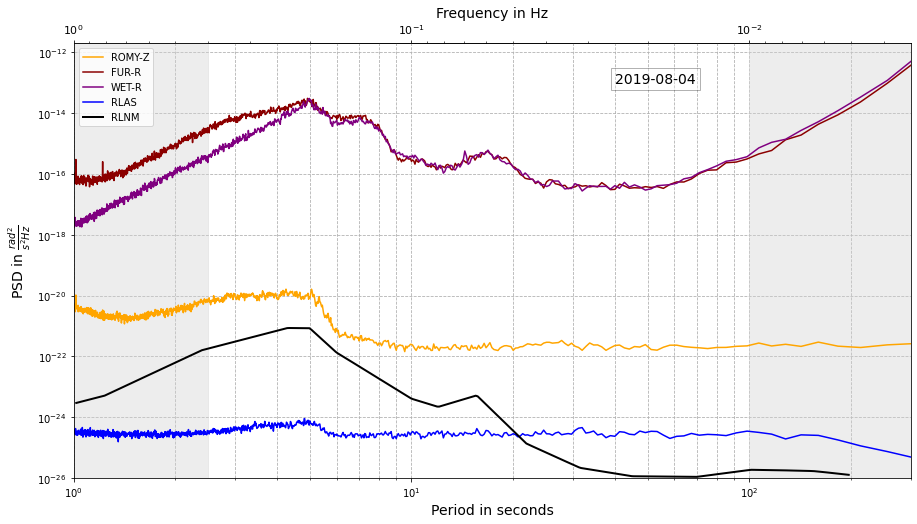

In [18]:
def __plot_rlnm_overview():
    
    import numpy as np
    
    font = 14

    fig, ax = plt.subplots(1,1,figsize=(15,8))

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
    ax2.set_xticklabels(1/periods, fontsize=11)
    
    ## single stations model
#     plt.plot(ssm_period, ssm_psd, color="purple", zorder=2, label="Single-Stations Model")
        

    ## PFO data
#     plt.plot(1/PFO_N['frequencies'], PFO_N_median_psd, color="darkgreen", zorder=2, label="PFO ADR-N")
#     plt.plot(1/PFO_E['frequencies'], PFO_E_median_psd, color="yellowgreen", zorder=2, label="PFO ADR-E")
#     plt.plot(1/PFO_Z['frequencies'], PFO_Z_median_psd, color="olive", zorder=2, label="PFO ADR-Z")
        
    ## romy data
    plt.plot(periods, romyz, color="orange", zorder=2, label="ROMY-Z")

    
    plt.plot(periods, rfur, color="darkred", zorder=2, label="FUR-R")
    plt.plot(periods, rwet, color="purple", zorder=2, label="WET-R")

    
    # romy data
#     plt.plot(romy_2022['frequencies'], romy_2022_median_psd, color="pink", zorder=2, label="ROMY-Z 2022")

    ## romy zne data
#     plt.plot(1/romy_zne['frequencies'], romy_zne['n_psd'], color="brown", zorder=2, label="ROMY-N")
#     plt.plot(1/romy_zne['frequencies'], romy_zne['e_psd'], color="chocolate", zorder=2, label="ROMY-E")

    ## rlas data
    plt.plot(periods[1:], rlasz[1:], color="blue", zorder=2, label="RLAS")

    ## theoretical rlnm
    plt.plot(rlnm_periods[1:], rlnm_psd[1:], color="black", zorder=2, lw=2, label="RLNM")


#     y_axis = 10**(output['bin_mids']/10)
#     x_axis = output['period']

    ## plotting

#     cmap = plt.cm.get_cmap('magma_r')
# #     cmap = plt.cm.get_cmap('gray_r')
#     cmap.set_under(color='white')

#     im = plt.pcolor(x_axis, y_axis, output['dist'].T, 
#                     cmap=cmap,
#                     vmin=1e-12, 
#                     alpha=0.99,
#                    )
    
    ## add medians 
#     medians = 10**(output['bins_medians']/10)
# #     plt.plot(output['period'], medians, color="black", zorder=2, lw=0.5, alpha=0.8, ls=":", label="median")
    
#     ## add minimas 
#     minimas = 10**(output['bins_minimum']/10)
#     plt.plot(output['period'], minimas, color="black", zorder=2, lw=1.5, alpha=0.8, label="RLNM")
    
    
#     ## add colorbar
#     caxes = fig.add_axes()
#     cb = plt.colorbar(im, cax=caxes, alpha=1.0)
#     cb.set_label("Propability Density", fontsize=font)
    
    
    plt.xscale("log")
    plt.yscale("log")

    plt.xlim(1, 300)

    ymin, ymax = 1e-26, 2e-12
    plt.ylim(ymin, ymax)
   
    plt.fill_betweenx(np.linspace(ymin,ymax,5), x1=0, x2=2.5, color="lightgrey", alpha=0.4, zorder=2)
    plt.fill_betweenx(np.linspace(ymin-10,ymax+10,5), x1=100, x2=300, color="lightgrey", alpha=0.4, zorder=2)


    plt.grid(axis="both", which="both", ls="--", zorder=0)
    plt.legend()

    plt.xlabel("Period in seconds", fontsize=font)
    plt.ylabel(r"PSD in $\frac{rad^2}{s^2 Hz}$",fontsize=font)

    plt.text(4e1, 1e-13, day, fontsize=font, bbox=dict(facecolor='white', alpha=0.3))
    
    plt.show();
    return fig 

fig = __plot_rlnm_overview()

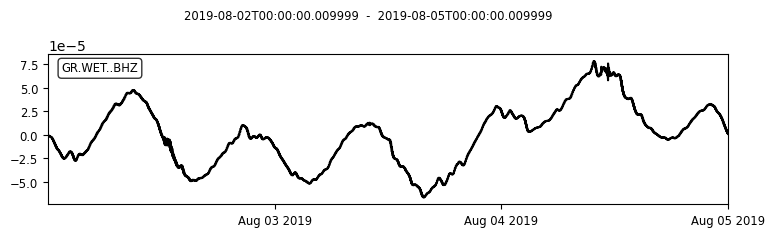

In [19]:
from andbro__querrySeismoData import __querrySeismoData



st0, inv0 = __querrySeismoData(
                    seed_id="GR.WET..BHZ",
                    starttime=UTCDateTime("2019-08-02"),
                    endtime=UTCDateTime("2019-08-05"),
                    repository="jane",
                    path=None,
                    restitute=True,
                    detail=None,
                    fill_value=-9999,
                    )
st0.plot();

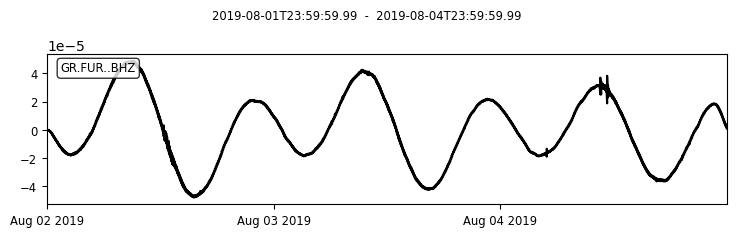

In [20]:
from andbro__querrySeismoData import __querrySeismoData



st0, inv0 = __querrySeismoData(
                    seed_id="GR.FUR..BHZ",
                    starttime=UTCDateTime("2019-08-02"),
                    endtime=UTCDateTime("2019-08-05"),
                    repository="jane",
                    path=None,
                    restitute=True,
                    detail=None,
                    fill_value=-9999,
                    )
st0.plot();

merged fragmented stream (fragments = 7)


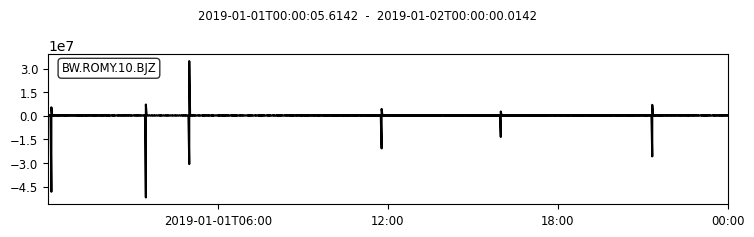

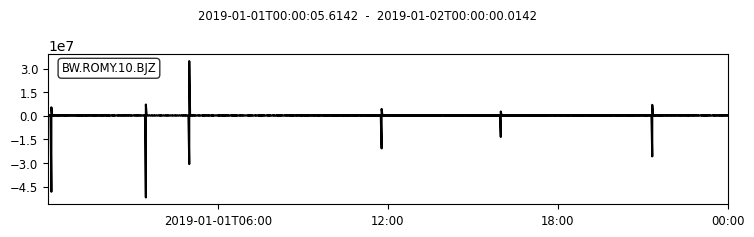

1 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2019-01-01T00:00:05.614200Z - 2019-01-02T00:00:00.014200Z | 20.0 Hz, 1727889 samples (masked)

In [25]:
from andbro__querrySeismoData import __querrySeismoData

st0, inv0 = __querrySeismoData(
                    seed_id="BW.ROMY.10.BJZ",
                    starttime=UTCDateTime("2019-01-01"),
                    endtime=UTCDateTime("2019-01-02"),
                    repository="archive",
                    path=None,
                    restitute=False,
                    detail=True,
#                     fill_value=-9999,
                    )


st0.plot();

st0